In [104]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from scipy import stats
import re

# Datasets de Inflación

In [105]:
inflacion_wb = pd.read_csv('../Inflacion/inflacion_world_bank.csv', encoding='latin1',  na_values='..')
inflacion_imf = pd.read_excel('../Inflacion/inflacion_imf.xls',  na_values='no data')

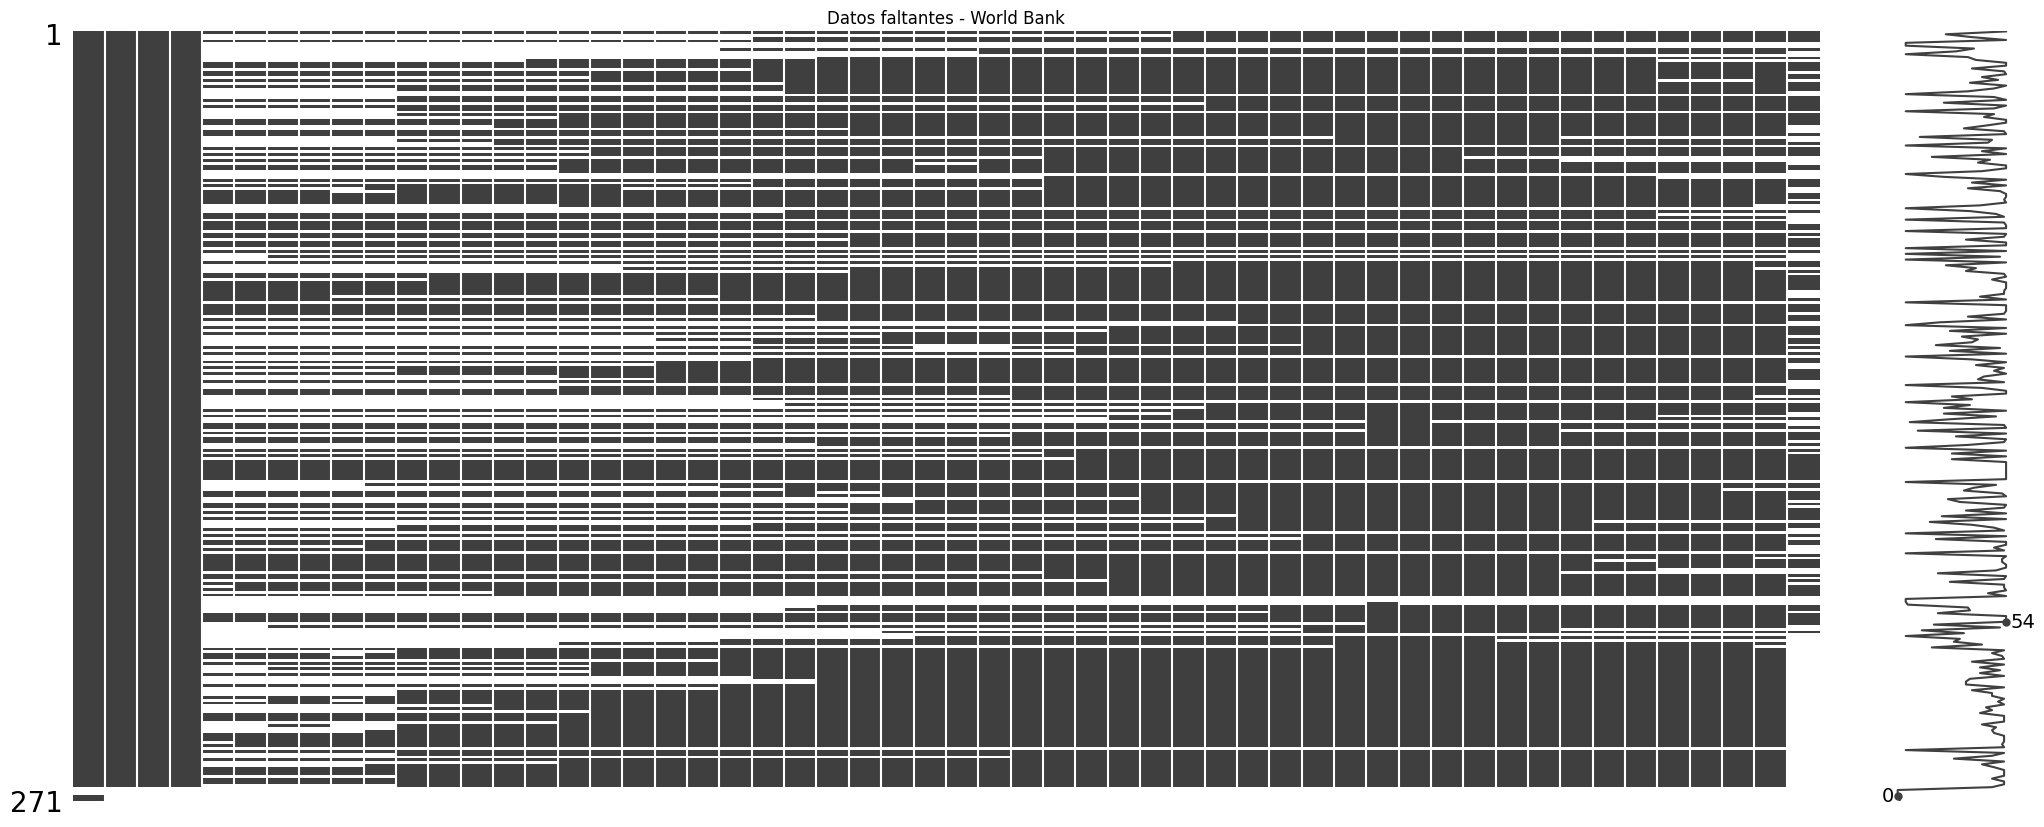

Dimensiones finales: (204, 54)
Ejemplo de datos limpios:
                             Series Name     Series Code              Country  \
0  Inflation, consumer prices (annual %)  FP.CPI.TOTL.ZG          Afghanistan   
1  Inflation, consumer prices (annual %)  FP.CPI.TOTL.ZG              Albania   
2  Inflation, consumer prices (annual %)  FP.CPI.TOTL.ZG              Algeria   
3  Inflation, consumer prices (annual %)  FP.CPI.TOTL.ZG  Antigua and Barbuda   
4  Inflation, consumer prices (annual %)  FP.CPI.TOTL.ZG                Aruba   

  ISO3       1975       1976       1977       1978       1979       1980  ...  \
0  AFG   5.253530   5.253530   5.253530   5.253530   5.253530   5.253530  ...   
1  ALB  14.360671  14.360671  14.360671  14.360671  14.360671  14.360671  ...   
2  DZA   8.230317   9.430735  11.989283  17.523923  11.348601   9.517824  ...   
3  ATG   2.120149   2.120149   2.120149   2.120149   2.120149   2.120149  ...   
4  ABW   2.957397   2.957397   2.957397   2.957397 

In [106]:
# ---------- a. Completar datos ----------
# 1. Visualizar valores faltantes
msno.matrix(inflacion_wb)
plt.title('Datos faltantes - World Bank')
plt.show()

# 2. Imputación simple: llenar con la media por país (fila)
wb_years = inflacion_wb.filter(regex=r'\d{4}')
inflacion_wb[wb_years.columns] = wb_years.T.fillna(wb_years.T.mean()).T

# ---------- b. Detección y eliminación de outliers ----------
# Usamos el criterio de valores z para cada fila (país)
def remove_outliers_z(df, threshold=3):
    df_numeric = df.select_dtypes(include=[np.number])
    z_scores = np.abs(stats.zscore(df_numeric, nan_policy='omit'))
    df_filtered = df[(z_scores < threshold).all(axis=1)]
    return df_filtered

# Guardar Israel antes de limpiar
israel_wb = inflacion_wb[inflacion_wb['Country Name'].str.strip() == 'Israel']
wb_clean = remove_outliers_z(inflacion_wb)

# Asegurar que Israel esté presente
if 'Israel' not in wb_clean['Country Name'].values:
    wb_clean = pd.concat([wb_clean, israel_wb], ignore_index=True)

# ---------- c. Forzar patrones y estandarizar ----------
# Estandarizamos nombres de columnas
wb_clean.columns = wb_clean.columns.str.strip().str.replace(r'\s*\[.*\]', '', regex=True)
wb_clean.rename(columns={'Country Name': 'Country', 'Country Code': 'ISO3'}, inplace=True)

# Aseguramos tipos adecuados
wb_clean['Country'] = wb_clean['Country'].astype(str)
wb_clean['ISO3'] = wb_clean['ISO3'].astype(str)

# ---------- d. De-duplicar datos relevantes ----------
wb_clean = wb_clean.drop_duplicates(subset=['Country', 'ISO3'])

print("Dimensiones finales:", wb_clean.shape)
print("Ejemplo de datos limpios:")
print(wb_clean.head())


In [107]:
wb_clean

,Series Name,Series Code,Country,ISO3,1975,1976,1977,1978,1979,1980,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,Afghanistan,AFG,5.253530,5.253530,5.253530,5.253530,5.253530,5.253530,...,-0.661709,4.383892,4.975952,0.626149,2.302373,5.601888,5.133203,13.712102,-4.644709,-6.601186
1,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,Albania,ALB,14.360671,14.360671,14.360671,14.360671,14.360671,14.360671,...,3.501208,-0.367317,2.060598,2.028060,1.411091,1.620887,2.041472,6.725203,4.759764,2.214490
2,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,Algeria,DZA,8.230317,9.430735,11.989283,17.523923,11.348601,9.517824,...,4.784447,6.397695,5.591116,4.269990,1.951768,2.415131,7.226063,9.265516,9.322174,4.046115
3,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,Antigua and Barbuda,ATG,2.120149,2.120149,2.120149,2.120149,2.120149,2.120149,...,0.968993,-0.489438,2.432488,1.207158,1.431356,0.625990,2.062996,7.531078,5.067139,2.120149
4,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,Aruba,ABW,2.957397,2.957397,2.957397,2.957397,2.957397,2.957397,...,0.474764,-0.931196,-1.028282,3.626041,4.257462,2.957397,2.957397,2.957397,2.957397,2.957397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,Sub-Saharan Africa (excluding high income),SSA,7.558215,7.558215,7.558215,7.558215,7.558215,7.558215,...,3.472388,5.494105,5.209717,4.274622,2.867588,3.842864,4.439055,9.459553,6.697600,7.558215
200,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,Sub-Saharan Africa (IDA & IBRD countries),TSS,18.311786,11.544881,14.890067,11.459430,13.674627,13.601983,...,3.550760,5.430520,5.197952,4.092978,2.835146,3.483936,4.618745,9.393839,6.342217,8.168887
201,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,Upper middle income,UMC,14.289674,10.813748,11.191002,10.660248,11.736231,18.035430,...,2.720641,2.106707,3.347578,2.830149,2.023907,1.890359,4.028529,8.640911,4.972462,8.057140
202,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,World,WLD,5.365736,5.365736,5.365736,5.365736,5.365736,5.365736,...,1.443857,1.605539,2.254277,2.442583,2.206073,1.905664,3.475403,7.930929,5.733163,5.365736


In [108]:
print("Número de columnas:", inflacion_imf.shape[1])
print("Columnas originales:", inflacion_imf.columns.tolist())


Número de columnas: 52
Columnas originales: ['Inflation rate, average consumer prices (Annual percent change)', 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030]


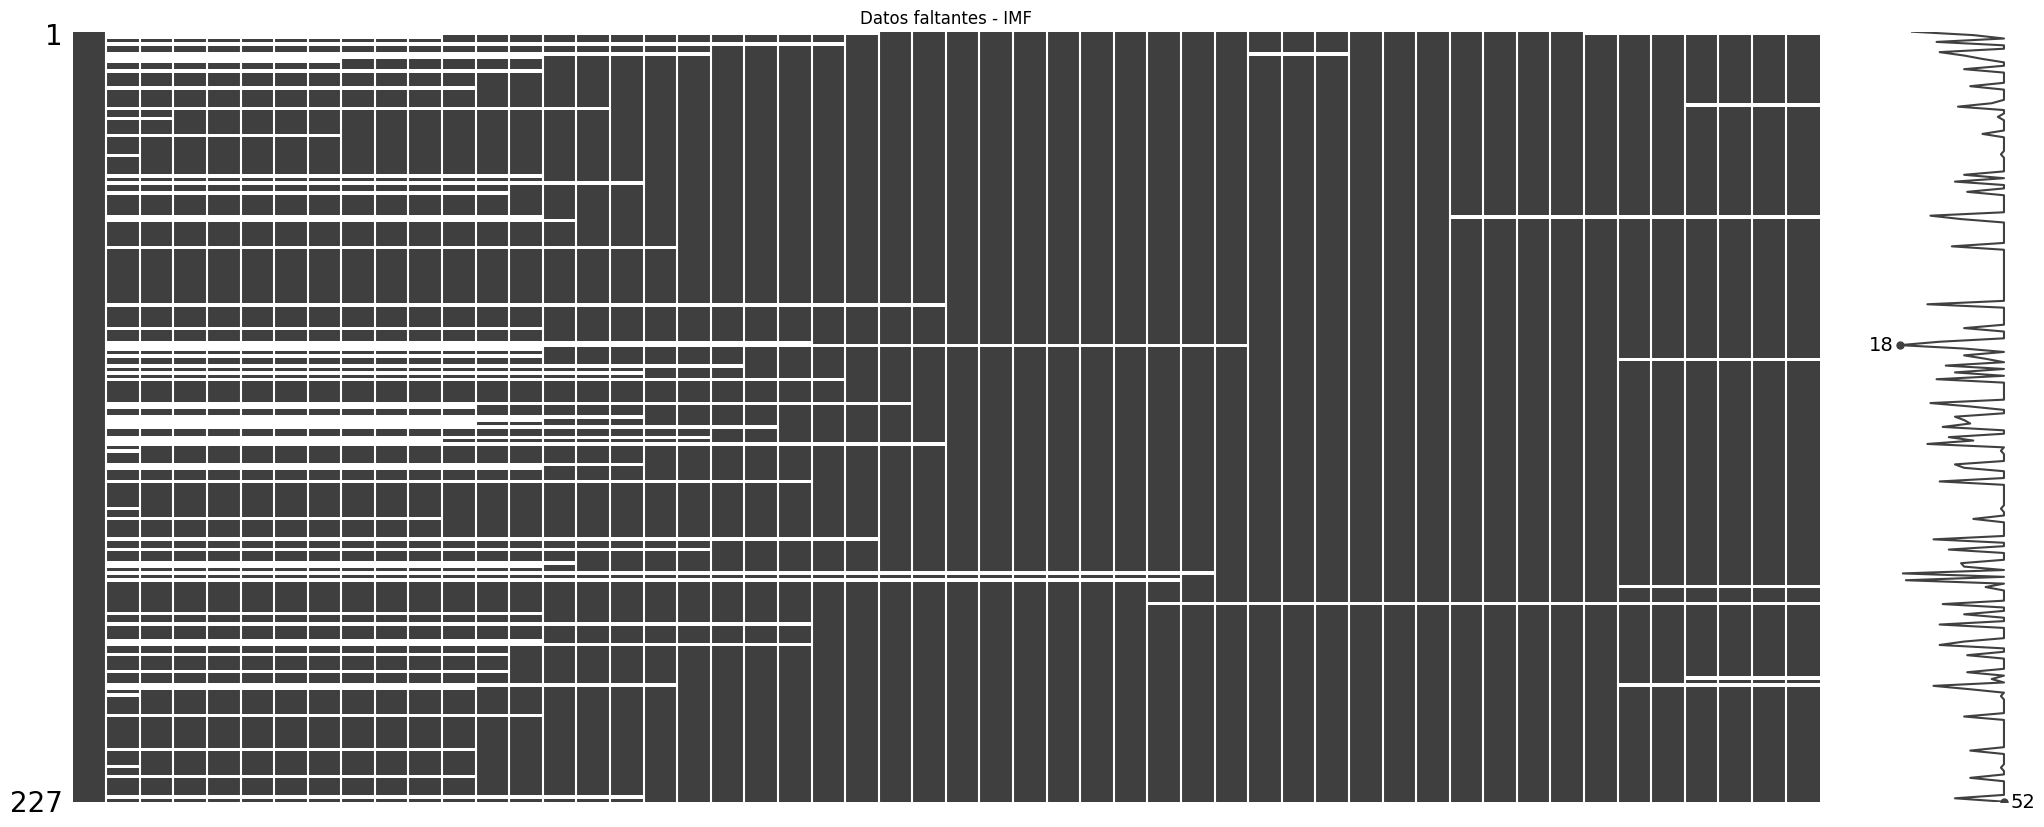

WB limpio: (204, 54)
IMF limpio: (185, 52)


In [109]:
# ---------- IMF ----------
# Quitar cabecera si es texto
if 'Inflation rate' in str(inflacion_imf.iloc[0, 0]):
    inflacion_imf = inflacion_imf.drop(index=0).reset_index(drop=True)

# Renombrar columnas
años = list(range(1980, 2031))
inflacion_imf.columns = ['Country'] + años
inflacion_imf = inflacion_imf[inflacion_imf['Country'].notna()].reset_index(drop=True)

# ---------- a. Imputación IMF ----------
msno.matrix(inflacion_imf)
plt.title('Datos faltantes - IMF')
plt.show()

year_cols = [col for col in inflacion_imf.columns if isinstance(col, int)]
inflacion_imf[year_cols] = inflacion_imf[year_cols].fillna(inflacion_imf[year_cols].mean())

# ---------- b. Eliminar outliers IMF ----------
israel_imf = inflacion_imf[inflacion_imf['Country'].str.strip() == 'Israel']

imf_clean = remove_outliers_z(inflacion_imf)
# Asegurar que Israel esté presente
if 'Israel' not in imf_clean['Country'].values:
    imf_clean = pd.concat([imf_clean, israel_imf], ignore_index=True)
# Asegurar que Israel esté presente
if 'Israel' not in imf_clean['Country'].values:
    imf_clean = pd.concat([imf_clean, israel_imf], ignore_index=True)

# ---------- c. Estándar tipos y nombres ----------
imf_clean['Country'] = imf_clean['Country'].astype(str).str.strip()

# ---------- d. Eliminar duplicados ----------
imf_clean = imf_clean.drop_duplicates(subset=['Country'])

# ---------- Mostrar resultados finales ----------
print("WB limpio:", wb_clean.shape)
print("IMF limpio:", imf_clean.shape)


In [110]:
imf_clean

,Country,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030
0,Albania,21.079394,17.254706,16.787135,18.415789,25.305263,89.905263,23.697076,97.301734,53.413295,...,2.0,6.7,4.8,2.2,2.4,2.7,3.0,3.0,3.0,3.0
1,Algeria,9.700000,14.600000,6.600000,7.800000,6.300000,10.400000,14.000000,5.900000,5.900000,...,7.2,9.3,9.3,4.0,3.7,3.6,3.4,3.3,3.3,3.2
2,Andorra,21.079394,17.254706,16.787135,18.415789,25.305263,89.905263,23.697076,97.301734,53.413295,...,1.7,6.2,5.6,3.1,2.2,1.8,1.7,1.7,1.7,1.7
3,Antigua and Barbuda,19.000000,11.500000,4.200000,2.300000,3.800000,1.000000,0.500000,3.600000,6.800000,...,1.6,7.5,5.1,6.4,3.5,2.4,2.0,2.0,2.0,2.0
4,Aruba,21.079394,17.254706,16.787135,18.415789,25.305263,89.905263,23.697076,3.600000,3.100000,...,0.7,5.5,3.4,1.7,1.5,1.9,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,Middle East and Central Asia,11.900000,11.200000,9.600000,9.000000,7.700000,7.100000,12.900000,17.600000,13.200000,...,11.9,13.4,15.5,14.4,11.1,9.9,8.3,7.1,6.3,6.1
181,Other advanced economies,25.600000,15.900000,13.100000,11.800000,18.200000,15.900000,5.900000,5.300000,5.700000,...,2.4,5.7,4.3,2.3,1.9,2.0,1.9,2.0,2.0,1.9
182,Sub-Saharan Africa,21.079394,17.254706,16.787135,18.415789,25.305263,89.905263,23.697076,97.301734,53.413295,...,11.6,15.2,17.6,18.3,13.3,12.9,8.5,8.3,7.2,6.7
183,World,17.300000,15.000000,14.300000,13.400000,14.000000,13.700000,11.700000,14.500000,19.100000,...,4.7,8.6,6.6,5.7,4.3,3.6,3.3,3.2,3.2,3.2


In [111]:
imf_clean.to_csv('../Inflacion/inflacion_imf_clean.csv', index=False)
wb_clean.to_csv('../Inflacion/inflacion_wb_clean.csv', index=False)

# Datasets de esperanza de vida al nacer

In [112]:
life_wb = pd.read_csv('../Life_expectancy/life_expectancy_world_bank.csv', encoding='latin1',  na_values='..')
life_un = pd.read_excel('../Life_expectancy/life_expectancy_united_nations.xls')

In [113]:
# Recortar life_wb hasta la fila donde 'Country Name' sea 'Zimbabwe'
idx = life_wb[life_wb['Country Name'] == 'Zimbabwe'].index.max()
life_wb = life_wb.loc[:idx].reset_index(drop=True)

In [114]:
life_wb

,Series Name,Series Code,Country Name,Country Code,1975 [YR1975],1976 [YR1976],1977 [YR1977],1978 [YR1978],1979 [YR1979],1980 [YR1980],...,2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022],2023 [YR2023],2024 [YR2024]
0,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,World,WLD,60.130488,60.453955,61.041175,61.394085,61.840715,62.151206,...,71.964577,72.184626,72.365025,72.642859,72.867669,72.182767,71.215376,72.968739,73.327475,NaN
1,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,Afghanistan,AFG,39.994000,40.518000,41.082000,40.086000,38.844000,39.258000,...,62.270000,62.646000,62.406000,62.443000,62.941000,61.454000,60.417000,65.617000,66.035000,NaN
2,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,Albania,ALB,68.120000,68.570000,68.992000,69.367000,69.617000,69.903000,...,78.358000,78.643000,78.900000,79.238000,79.467000,77.824000,76.844000,78.769000,79.602000,NaN
3,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,Algeria,DZA,46.921000,48.034000,49.249000,50.615000,52.409000,54.512000,...,75.159000,75.310000,75.431000,75.555000,75.682000,73.257000,75.208000,76.129000,76.261000,NaN
4,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,American Samoa,ASM,68.256000,68.475000,68.701000,68.881000,69.114000,69.413000,...,72.654000,72.640000,72.801000,72.794000,72.751000,72.672000,72.708000,72.752000,72.852000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,Virgin Islands (U.S.),VIR,67.679098,67.873171,68.073171,68.263683,68.464805,68.694878,...,79.017073,79.168293,79.368293,79.519512,79.668293,79.819512,80.068293,80.319512,80.519512,NaN
214,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,West Bank and Gaza,PSE,NaN,NaN,NaN,NaN,NaN,NaN,...,74.577000,74.917000,75.216000,75.380000,75.811000,74.998000,73.890000,76.662000,65.170000,NaN
215,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,"Yemen, Rep.",YEM,45.475000,46.441000,47.442000,48.484000,49.531000,50.608000,...,66.761000,67.105000,67.120000,65.915000,66.567000,66.435000,66.019000,67.952000,69.295000,NaN
216,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,Zambia,ZMB,55.742000,56.102000,56.281000,56.335000,56.050000,55.496000,...,60.728000,61.129000,61.564000,62.138000,62.914000,63.361000,62.363000,65.279000,66.349000,NaN


In [115]:
# Reestructurar life_wb para que tenga una columna por año
life_un = life_un[['Location', 'Iso3', 'Value', 'Time']] 

life_un = life_un.rename(columns={
    'Location': 'Country Name',
    'Iso3': 'Country Code',
    'Value': 'Life Expectancy',
    'Time': 'Year'
})

# Pivotear la tabla para que este en el formato ancho similar al de World Bank
life_un = life_un.pivot_table(
    index=['Country Name', 'Country Code'],
    columns='Year',
    values='Life Expectancy',
    aggfunc='mean'
).reset_index()

life_un

Year,Country Name,Country Code,1990,1991,1992,1993,1994,1995,1996,1997,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
0,Afghanistan,AFG,45.1183,45.5207,46.5691,51.0212,50.9689,52.1032,52.8302,53.2123,...,62.6459,62.4062,62.4434,62.9411,61.4537,60.4174,65.6170,66.0346,66.2893,66.5380
1,Albania,ALB,72.7096,73.0011,73.3030,73.6377,73.8367,74.0218,74.1134,73.3832,...,78.6433,78.9003,79.2377,79.4669,77.8241,76.8442,78.7688,79.6019,79.7764,79.9533
2,Algeria,DZA,67.6584,67.6919,67.7245,67.7974,67.2844,67.6914,68.2186,68.8594,...,75.3099,75.4313,75.5554,75.6818,73.2568,75.2077,76.1289,76.2610,76.4752,76.6866
3,American Samoa,ASM,71.1074,71.3120,71.5106,71.5399,71.5688,71.5652,71.5763,71.6065,...,72.6399,72.8009,72.7940,72.7511,72.6717,72.7080,72.7521,72.8518,72.9919,73.1256
4,Andorra,AND,78.9608,79.3458,79.7941,80.1860,80.5868,80.8037,81.0090,81.1446,...,84.4885,84.3595,84.2416,84.0980,79.4177,82.3311,84.0164,84.0406,84.1881,84.3305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,Wallis and Futuna Islands,WLF,69.9192,70.5849,71.1318,70.5926,71.9968,72.4950,73.1284,73.8346,...,77.5447,77.6279,77.7633,77.9936,78.1637,77.4609,78.5005,78.6286,78.7368,78.8974
232,Western Sahara,ESH,57.6610,58.1912,58.7132,59.2241,59.7437,60.2440,60.7200,61.2122,...,69.5959,69.8831,70.1433,70.3822,70.6126,70.8869,71.1432,71.3850,71.5803,71.7797
233,Yemen,YEM,58.5282,58.8053,59.2596,59.6551,59.8279,60.5324,60.8838,61.3404,...,67.1054,67.1198,65.9154,66.5673,66.4354,66.0191,67.9517,69.2952,69.4386,69.5796
234,Zambia,ZMB,48.2040,47.4431,46.9679,46.6781,46.3439,46.0509,45.7565,45.7429,...,61.1285,61.5644,62.1381,62.9145,63.3607,62.3631,65.2791,66.3487,66.5276,66.7003


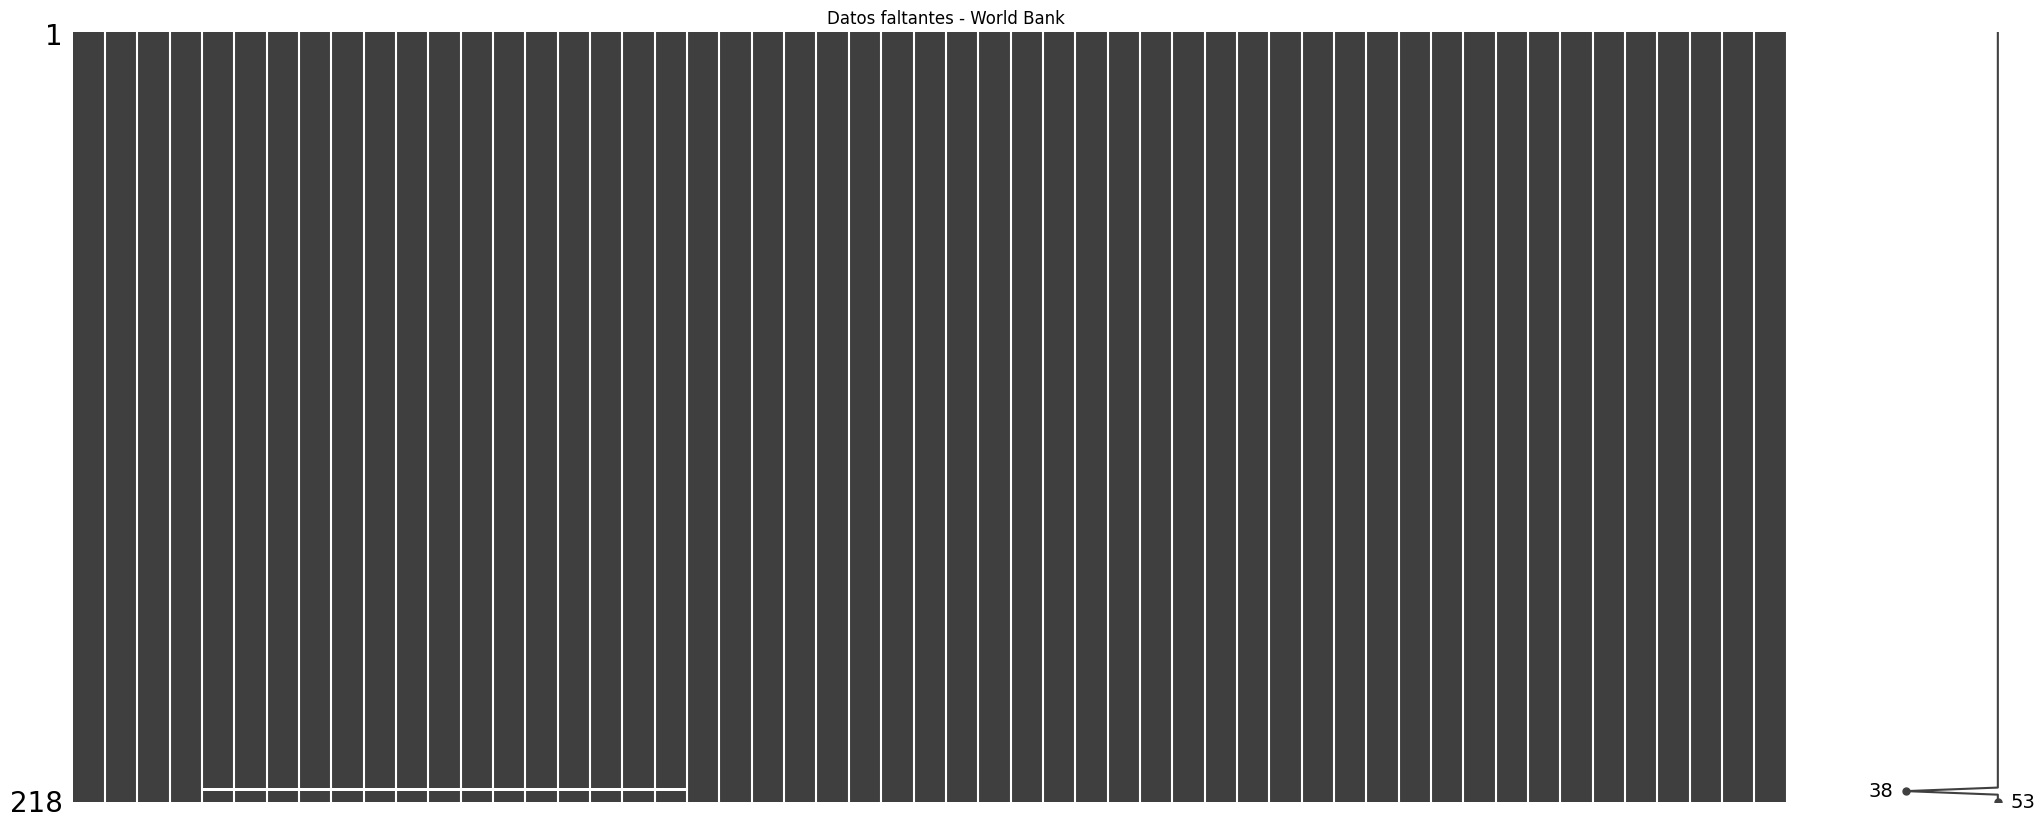

World Bank limpio: (214, 52)
          Country ISO3       1975       1976       1977       1978       1979  \
0           World  WLD  60.130488  60.453955  61.041175  61.394085  61.840715   
1     Afghanistan  AFG  39.994000  40.518000  41.082000  40.086000  38.844000   
2         Albania  ALB  68.120000  68.570000  68.992000  69.367000  69.617000   
3         Algeria  DZA  46.921000  48.034000  49.249000  50.615000  52.409000   
4  American Samoa  ASM  68.256000  68.475000  68.701000  68.881000  69.114000   

        1980       1981       1982  ...       2015       2016       2017  \
0  62.151206  62.516526  62.874101  ...  71.964577  72.184626  72.365025   
1  39.258000  39.406000  36.058000  ...  62.270000  62.646000  62.406000   
2  69.903000  70.145000  70.425000  ...  78.358000  78.643000  78.900000   
3  54.512000  57.422000  59.594000  ...  75.159000  75.310000  75.431000   
4  69.413000  69.731000  69.975000  ...  72.654000  72.640000  72.801000   

        2018       2019    

In [116]:
# 1. Visualizar faltantes
msno.matrix(life_wb)
plt.title('Datos faltantes - World Bank')
plt.show()

# 2. Eliminar columnas no necesarias y renombrar
life_wb_clean = life_wb.drop(columns=["Series Name", "Series Code"])
life_wb_clean.rename(columns={"Country Name": "Country", "Country Code": "ISO3"}, inplace=True)
life_wb_clean

# 3. Limpiar nombres de columnas año


def limpiar_columnas_years(columnas):
    nuevas = []
    for col in columnas:
        match = re.search(r"\b(19|20)\d{2}\b", col)
        if match:
            nuevas.append(match.group(0))  # Solo el año
        elif col in ['Country Name', 'Country Code']:
            nuevas.append({'Country Name': 'Country', 'Country Code': 'ISO3'}[col])
        else:
            nuevas.append(col)
    return nuevas

life_wb_clean.columns = limpiar_columnas_years(life_wb_clean.columns)
life_wb_clean


# 4. Imputar por año (columna)
year_cols_wb = [col for col in life_wb_clean.columns if col.isdigit()]
life_wb_clean[year_cols_wb] = life_wb_clean[year_cols_wb].apply(pd.to_numeric, errors='coerce')
life_wb_clean[year_cols_wb] = life_wb_clean[year_cols_wb].fillna(life_wb_clean[year_cols_wb].mean())

# 5. Eliminar outliers
def eliminar_filas_outliers(df, year_cols, min_val=20, max_val=95):
    # Creamos una máscara booleana donde True indica que hay al menos un valor fuera del rango en esa fila
    outlier_mask = df[year_cols].lt(min_val) | df[year_cols].gt(max_val)
    filas_con_outliers = outlier_mask.any(axis=1)
    
    # Conservamos solo las filas que NO tienen ningún valor fuera del rango
    return df[~filas_con_outliers].reset_index(drop=True)

year_cols_wb = [col for col in life_wb_clean.columns if str(col).isdigit()]
life_wb_clean = eliminar_filas_outliers(life_wb_clean, year_cols_wb, min_val=20, max_val=95)

# 6. De-duplicar
life_wb_clean = life_wb_clean.drop_duplicates(subset=['Country', 'ISO3'])

print("World Bank limpio:", life_wb_clean.shape)
print(life_wb_clean.head())




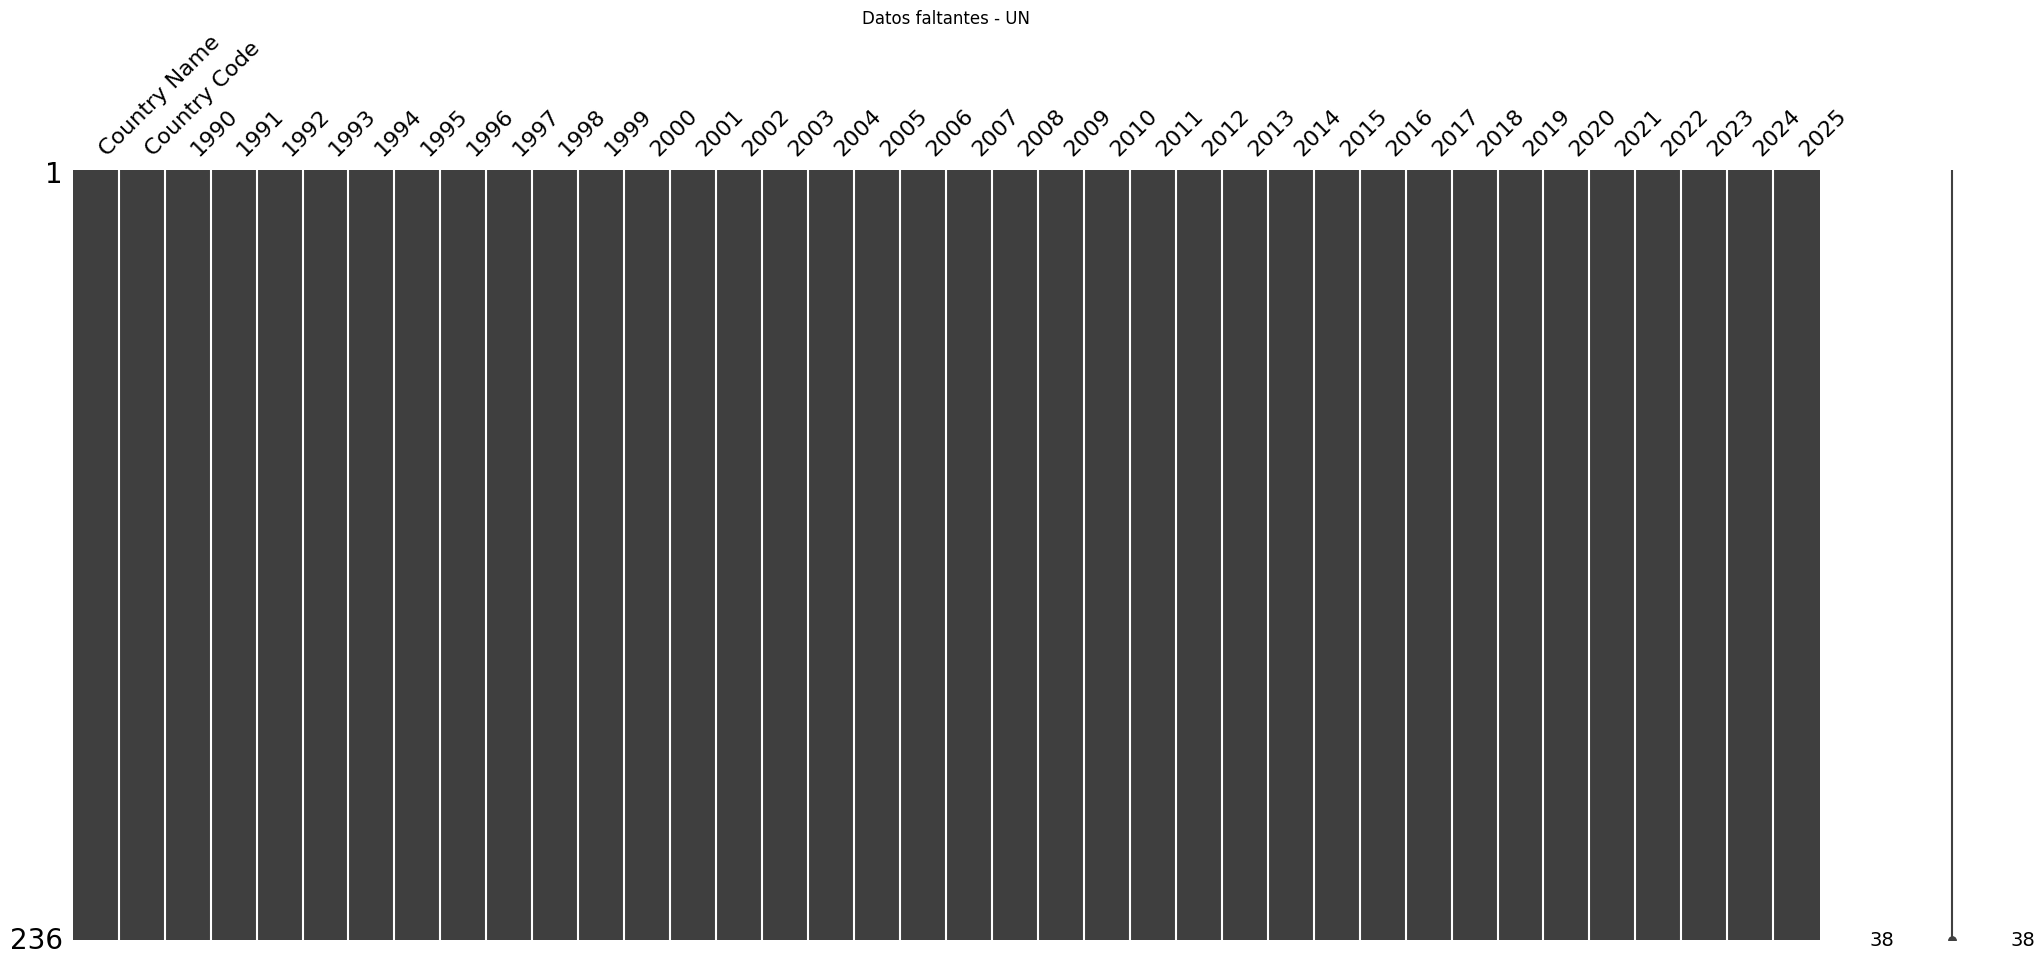

UN limpio: (236, 38)
Year         Country ISO3     1990     1991     1992     1993     1994  \
0        Afghanistan  AFG  45.1183  45.5207  46.5691  51.0212  50.9689   
1            Albania  ALB  72.7096  73.0011  73.3030  73.6377  73.8367   
2            Algeria  DZA  67.6584  67.6919  67.7245  67.7974  67.2844   
3     American Samoa  ASM  71.1074  71.3120  71.5106  71.5399  71.5688   
4            Andorra  AND  78.9608  79.3458  79.7941  80.1860  80.5868   

Year     1995     1996     1997  ...     2016     2017     2018     2019  \
0     52.1032  52.8302  53.2123  ...  62.6459  62.4062  62.4434  62.9411   
1     74.0218  74.1134  73.3832  ...  78.6433  78.9003  79.2377  79.4669   
2     67.6914  68.2186  68.8594  ...  75.3099  75.4313  75.5554  75.6818   
3     71.5652  71.5763  71.6065  ...  72.6399  72.8009  72.7940  72.7511   
4     80.8037  81.0090  81.1446  ...  84.4885  84.3595  84.2416  84.0980   

Year     2020     2021     2022     2023     2024     2025  
0     61.4537  6

In [117]:
# ---------- B. Limpieza para UN ----------

# 1. Visualizar faltantes
msno.matrix(life_un)
plt.title('Datos faltantes - UN')
plt.show()

# 2. Renombrar columnas
life_un_clean = life_un.rename(columns={"Country Name": "Country", "Country Code": "ISO3"})

# 3. Convertir nombres de columnas año a string por si acaso
year_cols_un = [col for col in life_un_clean.columns if str(col).isdigit()]
life_un_clean[year_cols_un] = life_un_clean[year_cols_un].apply(pd.to_numeric, errors='coerce')

# 4. Imputar por año (columna)
life_un_clean[year_cols_un] = life_un_clean[year_cols_un].fillna(life_un_clean[year_cols_un].mean())

# 5. Eliminar outliers por Z-score
life_un_clean = remove_outliers_z(life_un_clean, year_cols_un)

# 6. De-duplicar
life_un_clean = life_un_clean.drop_duplicates(subset=['Country', 'ISO3'])

print("UN limpio:", life_un_clean.shape)
print(life_un_clean.head())

In [118]:
life_wb_clean.to_csv('../Life_expectancy/life_expectancy_wb_clean.csv', index=False)
life_un_clean.to_csv('../Life_expectancy/life_expectancy_un_clean.csv', index=False)